In [1]:
!pip install --upgrade xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree._classes import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
file_path = '/Users/jenna/OneDrive/桌面/5010 Project/car_prices.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


## Data preprocessing

In [4]:
# drop rows with missing values & duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

### Column Reformation

In [5]:
df.rename(columns={'make': 'brand', 'body': 'body_type', 'odometer': 'mileage'}, inplace=True)

In [6]:
# dorp 'vin' column as it is not useful for our analysis
df.drop(columns=['vin'], inplace=True)

In [7]:
# calculate the sales year
df['sale_year'] = df['saledate'].str[11:15]
df['sale_year'] = pd.to_numeric(df['sale_year'], errors='coerce').astype('Int64')

In [8]:
df.head()

,year,brand,model,trim,body_type,transmission,state,condition,mileage,color,interior,seller,mmr,sellingprice,saledate,sale_year
0,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014
1,2015,Kia,Sorento,LX,SUV,automatic,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST),2014
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST),2014


In [9]:
df.shape

(472325, 16)

### Handling Extrme Values

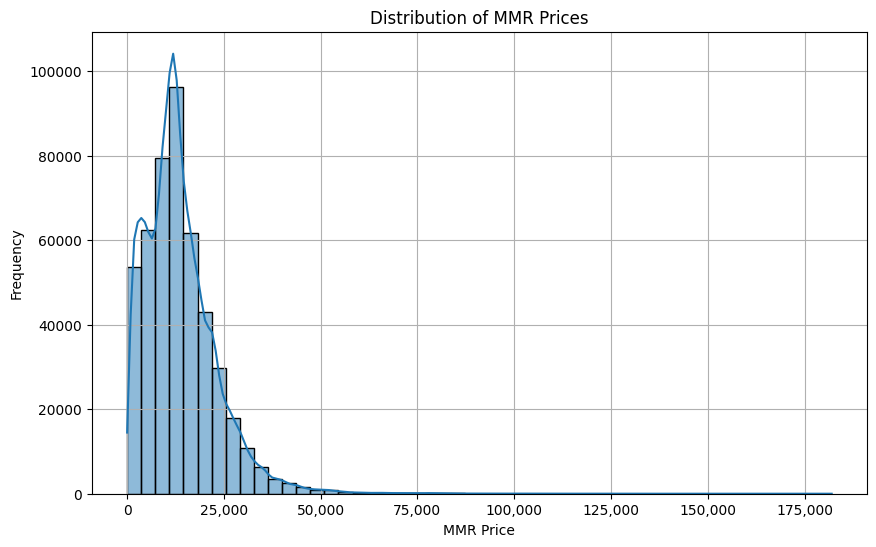

In [10]:
mmr_column = 'mmr'

plt.figure(figsize=(10, 6))
sns.histplot(df[mmr_column].dropna(), bins=50, kde=True)
plt.xlabel("MMR Price")
plt.ylabel("Frequency")
plt.title("Distribution of MMR Prices")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

    why choose this threshold?

In [11]:
mmr_column = 'mmr'

low_threshold = df[mmr_column].quantile(0.02)
high_threshold = df[mmr_column].quantile(0.98)

print(f"MMR lowwer {low_threshold:,.0f}")
print(f"MMR higher {high_threshold:,.0f}")

MMR lowwer 1,125
MMR higher 38,100


In [12]:
df['sale_year'].value_counts()

sale_year
2015    435536
2014     36789
Name: count, dtype: Int64

Since all sales are between 2014 & 2015, no need to adjust for inflation, can compare mmr & selling price at the same dollar value.

    why this threshold?

In [13]:
df = df[(df['mmr'] > 500) & (df['mmr'] < 45000)] 

df.shape

(466319, 16)

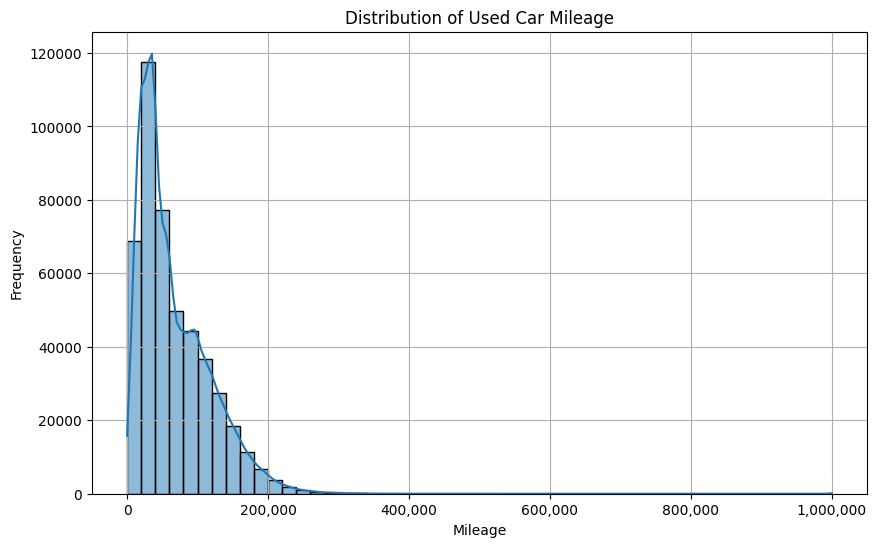

In [14]:
mileage_column = 'mileage'

plt.figure(figsize=(10, 6))
sns.histplot(df[mileage_column].dropna(), bins=50, kde=True)
plt.xlabel("Mileage")
plt.ylabel("Frequency")
plt.title("Distribution of Used Car Mileage")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

    again why this threshold

In [15]:
mileage_column = 'mileage'

low_threshold = df[mileage_column].quantile(0.02)
high_threshold = df[mileage_column].quantile(0.98)

print(f"mileage lowwer {low_threshold:,.0f}")
print(f"mileage higher {high_threshold:,.0f}")

mileage lowwer 6,147
mileage higher 194,577


In [16]:
df.shape

(466319, 16)

In [17]:
# new_df = df[(df['mileage'] > 5000) & (df['mileage'] < 200000)] 

# new_df.shape

In [18]:
# test_df = df[df['mileage'] > 200000] 
# test_df['mileage'].describe()

In [19]:
# test_df = df[df['mileage'] < 5000] 
# test_df['mileage'].describe()

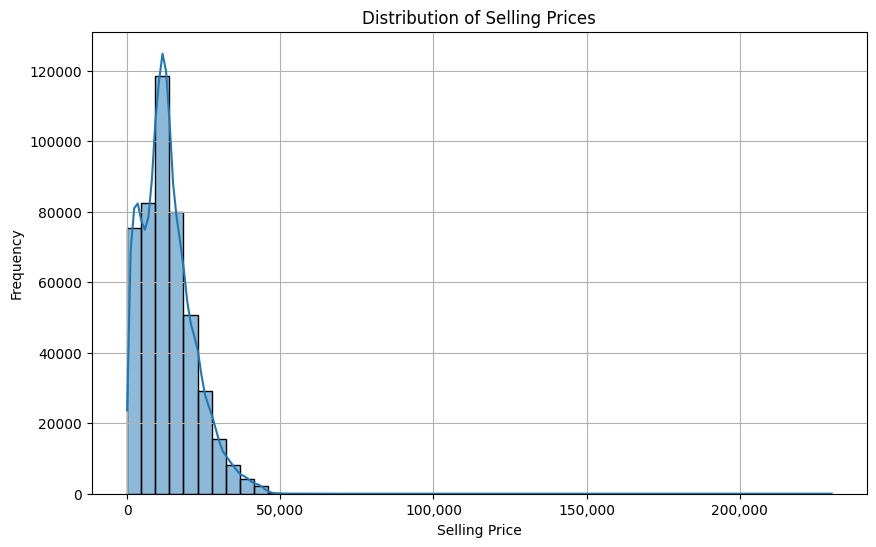

In [20]:
sellingprice_column = 'sellingprice'

plt.figure(figsize=(10, 6))
sns.histplot(df[sellingprice_column].dropna(), bins=50, kde=True)
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.title("Distribution of Selling Prices")
plt.grid(True)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [21]:
price = 'sellingprice'

low_threshold = df[price].quantile(0.02)
high_threshold = df[price].quantile(0.98)

print(f"price lowwer {low_threshold:,.0f}")
print(f"price higher {high_threshold:,.0f}")

price lowwer 900
price higher 35,000


In [22]:
df = df[(df['sellingprice'] > 1000) & (df['sellingprice'] < 45000)]

df.shape

(454009, 16)

For 'year' column, since manufacturing year cannot exceed sales year, drop any records that does not satisfy this condition.

In [23]:
df = df[df['year'] <= df['sale_year']]

df.shape

(453868, 16)

add a new column 'car_age' that calculate car's age based on sales_year - manufacuring_year

In [24]:
df['car_age'] = df['sale_year'] - df['year']

    need to output a csv file here as the outcome of data preprocessing module

In [25]:
# output df_cleaned to a csv file named 'car_prices_cleaned.csv'
# df_cleaned.to_csv('car_prices_cleaned.csv', index=False)

## MMR Factor Analysis

The Manheim Market Report (MMR) is the premier indicator a vehicle's prices.
  
    **Baseline Model**: Assume MMR properly reflects the current market value of each vahicle, we need to analyze how various factors affect its pricing, giving different makes and models, combined with mileage adjustment, condition adjustment, market class, etc,.


    need to read the preprocessed file after splitting notebook for different modules

In [26]:
# df_cleaned = pd.read_csv('car_prices_cleaned.csv')

In [27]:
df_mmr = df.copy()

In [28]:
df_mmr.head()

,year,brand,model,trim,body_type,transmission,state,condition,mileage,color,interior,seller,mmr,sellingprice,saledate,sale_year,car_age
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST),2015,1
3,2015,Volvo,S60,T5,Sedan,automatic,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST),2015,0
7,2014,Chevrolet,Cruze,1LT,Sedan,automatic,ca,2.0,28617.0,black,black,enterprise vehicle exchange / tra / rental / t...,11900.0,9800.0,Tue Dec 16 2014 13:00:00 GMT-0800 (PST),2014,0
8,2014,Audi,A4,2.0T Premium Plus quattro,Sedan,automatic,ca,42.0,9557.0,white,black,audi mission viejo,32100.0,32250.0,Thu Dec 18 2014 12:00:00 GMT-0800 (PST),2014,0
9,2014,Chevrolet,Camaro,LT,Convertible,automatic,ca,3.0,4809.0,red,black,d/m auto sales inc,26300.0,17500.0,Tue Jan 20 2015 04:00:00 GMT-0800 (PST),2015,1


### feature engineering

We need to explore what features relevant in impacting the calculation of depreciation rate per mileage.

In [29]:
# selecting relevant features based on empirical knowledge
relevant_features = ['brand','model', 'body_type', 'car_age', 'condition', 'transmission', 'mileage', 'mmr']
df_mmr = df_mmr[relevant_features]
df_mmr.head()

,brand,model,body_type,car_age,condition,transmission,mileage,mmr
2,BMW,3 Series,Sedan,1,45.0,automatic,1331.0,31900.0
3,Volvo,S60,Sedan,0,41.0,automatic,14282.0,27500.0
7,Chevrolet,Cruze,Sedan,0,2.0,automatic,28617.0,11900.0
8,Audi,A4,Sedan,0,42.0,automatic,9557.0,32100.0
9,Chevrolet,Camaro,Convertible,1,3.0,automatic,4809.0,26300.0


In [30]:
df_mmr['brand'].value_counts().shape

(47,)

In [31]:
df_mmr['model'].value_counts().shape

(706,)

In [32]:
df_mmr['body_type'].value_counts().shape

(82,)

In [33]:
df_mmr['transmission'].value_counts().shape

(2,)

Since different brands have vary different names for model, so the column 'model' itself does not apply to our factor analysis. **Drop it** <br>
Both 'brand' and 'body_type' are high dimensional categorical variables --> use label encoding to convert them to numeric values

In [34]:
df_mmr.drop('model', axis=1, inplace=True)
df_mmr.head()

,brand,body_type,car_age,condition,transmission,mileage,mmr
2,BMW,Sedan,1,45.0,automatic,1331.0,31900.0
3,Volvo,Sedan,0,41.0,automatic,14282.0,27500.0
7,Chevrolet,Sedan,0,2.0,automatic,28617.0,11900.0
8,Audi,Sedan,0,42.0,automatic,9557.0,32100.0
9,Chevrolet,Convertible,1,3.0,automatic,4809.0,26300.0


In [35]:
from sklearn.preprocessing import LabelEncoder

In [36]:
# label encoding for categorical features
le = LabelEncoder()
df_mmr['brand'] = le.fit_transform(df_mmr['brand'])
df_mmr['body_type'] = le.fit_transform(df_mmr['body_type'])
df_mmr['transmission'] = le.fit_transform(df_mmr['transmission'])
df_mmr.head()

,brand,body_type,car_age,condition,transmission,mileage,mmr
2,3,34,1,45.0,0,1331.0,31900.0
3,45,34,0,41.0,0,14282.0,27500.0
7,7,34,0,2.0,0,28617.0,11900.0
8,2,34,0,42.0,0,9557.0,32100.0
9,7,8,1,3.0,0,4809.0,26300.0


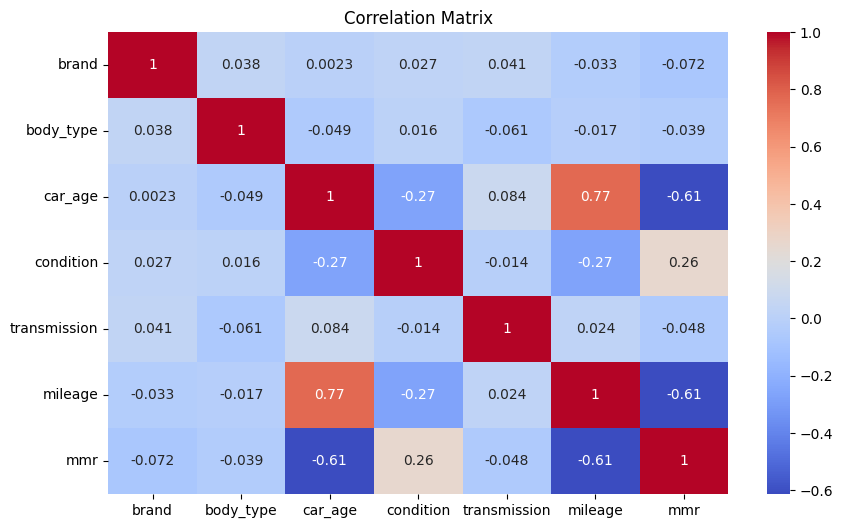

In [37]:
# conduct correlation analysis to remove multicollinearity
corr_matrix = df_mmr.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In this correlation matrix, **'car age' and 'mileage'** show a high correlation, so we need to drop one feature to prevent multicollinearity.
<br>
We decided to select 'mileage' for training  as it best indicate each vehicle's depreciation. 

In [38]:
df_mmr.drop('car_age', axis=1, inplace=True)
df_mmr.head()

,brand,body_type,condition,transmission,mileage,mmr
2,3,34,45.0,0,1331.0,31900.0
3,45,34,41.0,0,14282.0,27500.0
7,7,34,2.0,0,28617.0,11900.0
8,2,34,42.0,0,9557.0,32100.0
9,7,8,3.0,0,4809.0,26300.0


In [39]:
# standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_mmr[[ 'condition', 'brand', 'body_type', 'transmission', 'mileage', 'mmr']] = scaler.fit_transform(df_mmr[[ 'condition', 'brand', 'body_type', 'transmission', 'mileage', 'mmr']])
df_mmr.head()

,brand,body_type,condition,transmission,mileage,mmr
2,-1.262371,-0.188425,1.061583,-0.186013,-1.298652,2.235826
3,2.066911,-0.188425,0.752880,-0.186013,-1.032008,1.694450
7,-0.945296,-0.188425,-2.256971,-0.186013,-0.736870,-0.224974
8,-1.341640,-0.188425,0.830056,-0.186013,-1.129289,2.260434
9,-0.945296,-1.712004,-2.179795,-0.186013,-1.227044,1.546802


### Model training

I choose decision tree model as a baseline model given the presumption that the depreciation rate is primarily driven by mileage, and I want to explore how other relevant features can impact the depreciation rate

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X, y = df_mmr.drop(columns=['mmr']), df_mmr['mmr']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# make sure training data & test data have the same number of features and acceptable number of samples
print(X_train.shape)
print(X_test.shape)

(363094, 5)
(90774, 5)


In [43]:
from sklearn.tree._classes import DecisionTreeRegressor

In [44]:
# train a decision tree model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [45]:
# make predictions
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

**success metrics**: use RMSE to measure the error of predictions on both training & test data

In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Model Training RMSE: {train_rmse:.2f}")
print(f"Model Test RMSE: {test_rmse:.2f}")

Model Training RMSE: 0.02
Model Test RMSE: 0.67


In [47]:
# print the coefficient of the decision tree model 
for feature, importance in zip(X.columns, dt.feature_importances_):
    print(f"{feature}: {importance:.2f}")

brand: 0.17
body_type: 0.19
condition: 0.06
transmission: 0.00
mileage: 0.58


Results not good, try more complex model.

#### Random forest

In [48]:
# use random forest regressor
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [49]:
# make predictions
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

In [50]:
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Model Training RMSE: {train_rmse:.2f}")
print(f"Model Test RMSE: {test_rmse:.2f}")

Model Training RMSE: 0.19
Model Test RMSE: 0.52


In [51]:
# print the coefficient of the decision tree model 
for feature, importance in zip(X.columns, rfr.feature_importances_):
    print(f"{feature}: {importance:.2f}")

brand: 0.17
body_type: 0.19
condition: 0.07
transmission: 0.00
mileage: 0.57


#### XGBoost

In [52]:
# use xgboost to train a regression model
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [53]:
# make predictions
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

In [54]:
# calculate r squared score of the model
train_r2 = xgb.score(X_train, y_train)
test_r2 = xgb.score(X_test, y_test)
print(f"Model Training R^2: {train_r2:.2f}")
print(f"Model Test R^2: {test_r2:.2f}")

Model Training R^2: 0.78
Model Test R^2: 0.77


In [55]:
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Model Training RMSE: {train_rmse:.2f}")
print(f"Model Test RMSE: {test_rmse:.2f}")

Model Training RMSE: 0.47
Model Test RMSE: 0.48


In [56]:
# print the coefficient of the xgboost model
for feature, importance in zip(X.columns, xgb.feature_importances_):
    print(f"{feature}: {importance:.2f}")

brand: 0.19
body_type: 0.22
condition: 0.05
transmission: 0.02
mileage: 0.52


After training with different non-linear tree models, xgboost outperforms other models by yielding a r^2 score of **0.77**  and the smallest RMSE of **0.48** without overfitting. This model shows that the top dominant feature affecting mmr is **'mileage'** with a feature importance of 0.52.

**However, we suspected different brands and models should have stronger impact on the MMR of each vehicle, but we simply label encoded the two columns in our baseline model.**

    In this case, we need to take a deeper dive into the specific brands and models in our dataset, and segment different types of cars (ex.SUV, economics, etc.,) and optimize our model with empirical knowledge.

In [57]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0]
}

xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE (CV):", (-grid_search.best_score_)**0.5)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Best RMSE (CV): 0.4726089555719258


In [58]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

best_params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'n_estimators': 200,
    'subsample': 1.0,
    'random_state': 42
}

xgb = XGBRegressor(**best_params)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

for feature, importance in zip(X.columns, xgb.feature_importances_):
    print(f"{feature}: {importance:.2f}")

Test RMSE: 0.4730
Test R²: 0.7773
brand: 0.20
body_type: 0.23
condition: 0.04
transmission: 0.02
mileage: 0.51


#### XGBoost Model Tuning Summary

Initially, we trained an XGBoost regression model using default parameters to predict the market value (MMR) of vehicles. While the model performed reasonably well (Test RMSE ≈ 0.48, R² ≈ 0.77), we aimed to further improve its performance and robustness through hyperparameter tuning using `GridSearchCV`.

##### Tuning Objective

To optimize the model's ability to generalize on unseen data by adjusting key parameters that control its learning process and complexity.

##### Parameter Grid Used

We searched across the following parameter combinations:

- `learning_rate`: [0.01, 0.1, 0.3]
- `max_depth`: [3, 5, 7]
- `n_estimators`: [50, 100, 200]
- `subsample`: [0.7, 1.0]

This resulted in 54 combinations, and we performed 3-fold cross-validation on each (162 fits in total).

##### Best Parameters Found

```python
{
    'learning_rate': 0.1,
    'max_depth': 7,
    'n_estimators': 200,
    'subsample': 1.0
}

### top 10 Brands that has been dealt with

In [59]:
print("\nUnique Brand:", df['brand'].nunique())


Unique Brand: 47


In [60]:
# Find the top 10 best-selling brands
top_brands = df['brand'].value_counts().nlargest(10).index

df_price = df[df['brand'].isin(top_brands)]

In [61]:
print("\nUnique Brands:", df_price['brand'].nunique())
print("\nUnique models:", df_price['model'].nunique())


Unique Brands: 10

Unique models: 278


### market category mapping preparation¶

In [62]:
unique_models_list = df_price.groupby("brand")["model"].unique().reset_index()

unique_models_list.columns = ["brand", "unique_models"]

unique_models_dict = unique_models_list.set_index("brand")["unique_models"].to_dict()

unique_models_dict

{'BMW': array(['3 Series', '5 Series', 'X1', '4 Series', '6 Series', '7 Series',
        '1 Series', 'M3', 'X3', 'X5', 'Z4', 'X6', '5 Series Gran Turismo',
        'M5', 'Z3', 'M', 'ActiveHybrid X6', 'X6 M', 'M6', '2 Series',
        '3 Series Gran Turismo', 'ActiveHybrid 7', 'Z4 M', 'X5 M',
        'ActiveHybrid 5', '8 Series', '6 Series Gran Coupe',
        '4 Series Gran Coupe'], dtype=object),
 'Chevrolet': array(['Cruze', 'Camaro', 'Impala', 'Malibu', 'Silverado 1500',
        'Traverse', 'Silverado 2500HD', 'Equinox', 'Captiva Sport', 'Volt',
        'Express Cargo', 'Colorado', 'Express', 'Sonic', 'Suburban', 'HHR',
        'Tahoe', 'Impala Limited', 'Aveo', 'Corvette', 'malibu',
        'Avalanche', 'Tahoe Hybrid', 'Malibu Classic', 'Cobalt',
        'Uplander', 'Silverado 1500 Classic', 'Monte Carlo', 'TrailBlazer',
        'Malibu Maxx', 'S-10', 'Silverado 1500HD', 'Spark', 'SSR',
        'Silverado 3500HD', 'Silverado 1500 Hybrid',
        'Silverado 2500HD Classic', 'Silver

### Add in new column market_category
### making a market category map defining which models are what market category

### Why I Created a `car category` Column

The original `model` column is too fragmented for meaningful analysis. Each model, like "Altima", "F-150", or "3 Series", is treated as a separate group, making it difficult to compare or identify trends across similar types of vehicles.

By creating a custom `car category` column, I grouped vehicles into broader, more meaningful categories such as "Economy Sedan", "Luxury SUV", or "Pickup Truck". This allows for:

- Comparing **average prices** across different types of cars  
- Analyzing which **vehicle categories sell the most**  
- Performing **grouped statistics and visualizations** more effectively

In short, while `model` gives specific car names, `car category` gives general types. This makes the analysis more interpretable and actionable.


In [63]:
market_category_map = {
    "Economy Sedan": [
        "Altima", "Focus", "Impala", "Sonata", "Cruze", "Taurus",
        "Optima", "200", "Avenger", "Passat", "Civic", "Corolla",
        "Fusion", "Malibu", "Sentra", "Elantra", "Jetta", "Accord",
        "Camry", "Versa", "Rio", "Yaris"    ],
    "Luxury Sedan": [
        "3 Series", "5 Series", "7 Series", "A4", "A6", "A8", "C-Class", 
        "E-Class", "S-Class", "S60", "S90", "TLX", "Q50", "Genesis",
        "Maxima", "300", "G Sedan", "LS", "ES", "IS"    ],
    "Sports Sedan": [
        "M3", "M5", "Charger", "S4", "CTS-V", "IS F", "XFR", "WRX"    ],
    "Economy SUV": [
        "Explorer", "Edge", "Journey", "Escape", "Rogue", "Tucson",
        "Equinox", "Sorento", "CX-5", "CR-V", "RAV4", "Highlander",
        "Santa Fe", "Kicks", "HR-V", "Sportage"    ],
    "Luxury SUV": [
        "Grand Cherokee", "X5", "X3", "Q7", "Q5", "GLC", "GLA", 
        "RX", "LX", "Cayenne", "MDX", "Escalade", "Navigator",
        "GLE", "Macan", "XC90", "Tahoe" ],
    "Off-Road SUV": [
        "Wrangler", "4Runner", "Bronco", "Defender", "G-Class"    ],
    "Pickup Truck": [
        "1500", "F-150", "Silverado 1500", "Ram Pickup 1500", 
        "Tacoma", "Tundra", "Ranger", "Colorado", "Frontier"    ],
    "Electric Vehicle": [
        "Leaf", "Model S", "Model 3", "Model X", "Model Y",
        "Bolt", "i3", "i4", "Polestar 2", "Mach-E"    ],
    "Sports Car": [
        "Mustang", "Camaro", "Corvette", "370Z", "911", "M4",
        "Supra", "GT-R", "F-Type", "718 Cayman"    ],
    "Minivan": [
        "Sienna", "Odyssey", "Grand Caravan", "Town and Country",
        "Quest", "Pacifica", "Sedona"    ],
    "Hybrid Car": [
        "Prius", "Camry Hybrid", "Accord Hybrid", "Fusion Hybrid",
        "Highlander Hybrid", "RAV4 Hybrid"    ]
}

def get_market_category(brand, model):
    model = str(model)  
    for category, models in market_category_map.items():
        if any(model.startswith(m) for m in models):
            return category
    return "Other"  

df_price["market_category"] = df_price.apply(lambda x: get_market_category(x["brand"], x["model"]), axis=1)


C:\Users\jenna\AppData\Local\Temp\ipykernel_19788\3310696113.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price["market_category"] = df_price.apply(lambda x: get_market_category(x["brand"], x["model"]), axis=1)


In [64]:
print("\nUnique Category:", df_price['market_category'].nunique())

# count other 
other_count = df_price["market_category"].value_counts().get("Other", 0)

print(f'count other: {other_count}')


Unique Category: 12
count other: 63163


In [65]:
other_models_count = (
    df_price[df_price["market_category"] == "Other"]
    .groupby(["brand", "model"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
    .head(20)
)

other_models_count

,brand,model,count
137,Kia,Forte,2469
141,Kia,Soul,2437
147,Nissan,Murano,2431
103,Ford,Fiesta,2214
100,Ford,F-250 Super Duty,2113
98,Ford,Expedition,2103
50,Chevrolet,Suburban,1918
120,Honda,Pilot,1815
54,Chevrolet,Traverse,1777
125,Hyundai,Accent,1704


In [66]:
# renew market category

market_category_map = {
    "Economy Sedan": [
        "Altima", "Focus", "Impala", "Sonata", "Cruze", "Taurus",
        "Optima", "200", "Avenger", "Passat", "Civic", "Corolla",
        "Fusion", "Malibu", "Sentra", "Elantra", "Jetta", "Accord",
        "Camry", "Versa", "Rio", "Yaris", "Forte", "Fiesta", "Sonic", "Cobalt", "Sebring"],
    
    "Luxury Sedan": [
        "3 Series", "5 Series", "7 Series", "A4", "A6", "A8", "C-Class", 
        "E-Class", "S-Class", "S60", "S90", "TLX", "Q50", "Genesis",
        "Maxima", "300", "G Sedan", "LS", "ES", "IS"],
    
    "Sports Sedan": [
        "M3", "M5", "Charger", "S4", "CTS-V", "IS F", "XFR", "WRX"],
    
    "Economy SUV": [
        "Explorer", "Edge", "Journey", "Escape", "Rogue", "Tucson",
        "Equinox", "Sorento", "CX-5", "CR-V", "RAV4", "Highlander",
        "Santa Fe", "Kicks", "HR-V", "Sportage", "Soul", "Pilot", "Pathfinder", "Traverse", "Durango"],
    
    "Luxury SUV": [
        "Grand Cherokee", "X5", "X3", "Q7", "Q5", "GLC", "GLA", 
        "RX", "LX", "Cayenne", "MDX", "Escalade", "Navigator",
        "GLE", "Macan", "XC90", "Tahoe", "Suburban", "Murano", "Expedition"],
    
    "Off-Road SUV": [
        "Wrangler", "4Runner", "Bronco", "Defender", "G-Class"],
    
    "Pickup Truck": [
        "1500", "F-150", "Silverado 1500", "Ram Pickup 1500", 
        "Tacoma", "Tundra", "Ranger", "Colorado", "Frontier", "F-250 Super Duty", "Silverado 2500HD"],
    
    "Electric Vehicle": [
        "Leaf", "Model S", "Model 3", "Model X", "Model Y",
        "Bolt", "i3", "i4", "Polestar 2", "Mach-E"],
    
    "Sports Car": [
        "Mustang", "Camaro", "Corvette", "370Z", "911", "M4",
        "Supra", "GT-R", "F-Type", "718 Cayman"],
    
    "Minivan": [
        "Sienna", "Odyssey", "Grand Caravan", "Town and Country",
        "Quest", "Pacifica", "Sedona"],
    
    "Hybrid Car": [
        "Prius", "Camry Hybrid", "Accord Hybrid", "Fusion Hybrid",
        "Highlander Hybrid", "RAV4 Hybrid"],
    
    "Economy Hatchback": [
        "Caliber", "PT Cruiser", "Accent"],
}


def get_market_category(brand, model):
    model = str(model) 
    for category, models in market_category_map.items():
        if any(model.startswith(m) for m in models):
            return category
    return "Other"  

df_price["market_category"] = df_price.apply(lambda x: get_market_category(x["brand"], x["model"]), axis=1)

C:\Users\jenna\AppData\Local\Temp\ipykernel_19788\517562864.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price["market_category"] = df_price.apply(lambda x: get_market_category(x["brand"], x["model"]), axis=1)


In [67]:
print("\nUnique Category:", df_price['market_category'].nunique())

# count other 
other_count = df_price["market_category"].value_counts().get("Other", 0)

print(f'count other: {other_count}')


Unique Category: 13
count other: 31458


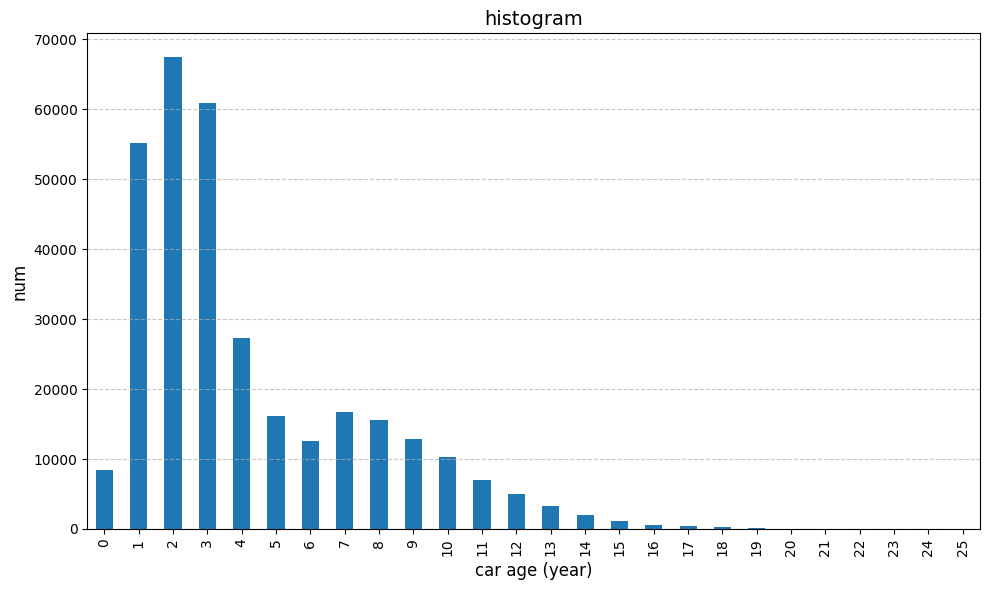

In [68]:
plt.figure(figsize=(10, 6))
df_price['car_age'].value_counts().sort_index().plot(kind='bar')

plt.title('histogram', fontsize=14)
plt.xlabel('car age (year)', fontsize=12)
plt.ylabel('num', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

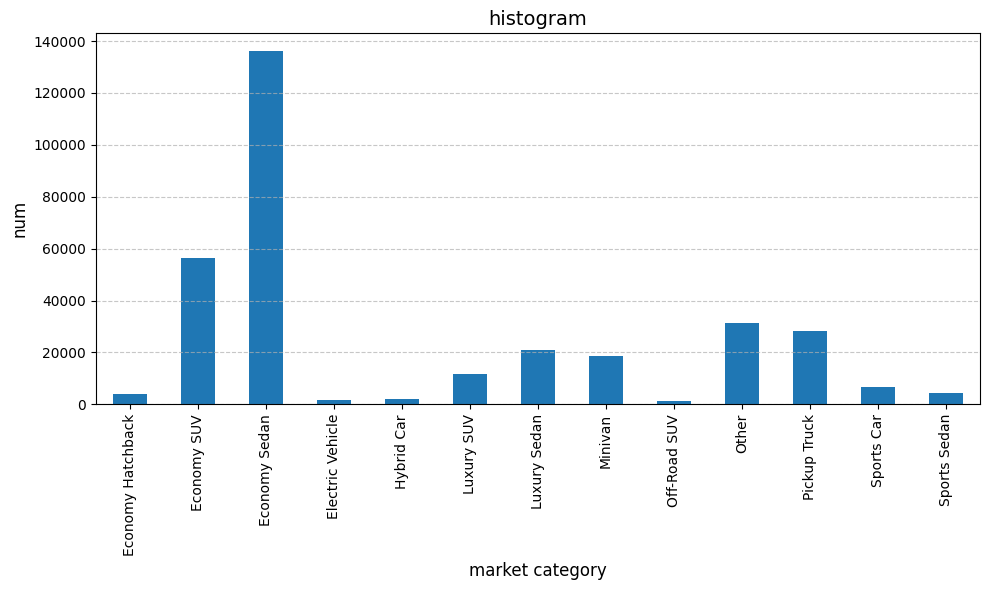

In [69]:
plt.figure(figsize=(10, 6))
df_price['market_category'].value_counts().sort_index().plot(kind='bar')

plt.title('histogram', fontsize=14)
plt.xlabel('market category', fontsize=12)
plt.ylabel('num', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

## features that make the most contribution to selling price

In [70]:
!pip install category-encoders

In [71]:
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

# Define feature categories
num_features = ['condition', 'mileage', 'car_age']
low_card_cat_features = ['transmission', 'color', 'interior']
high_card_cat_features = ['brand', 'trim', 'state', 'market_category']
target = 'sellingprice'

# Split the dataset
train, test = train_test_split(df_price, test_size=0.2, random_state=42)

# One-Hot Encoding for low-cardinality categorical features
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
train_ohe = ohe.fit_transform(train[low_card_cat_features])
test_ohe = ohe.transform(test[low_card_cat_features])

# Target Encoding for high-cardinality categorical features
te = TargetEncoder()
train_te = te.fit_transform(train[high_card_cat_features], train[target])
test_te = te.transform(test[high_card_cat_features])

# Combine processed features
X_train = np.hstack((train[num_features].values, train_ohe, train_te))
X_test = np.hstack((test[num_features].values, test_ohe, test_te))

y_train = train[target].values
y_test = test[target].values

# Ensure feature dimensions are reasonable after processing
print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (258676, 43)
Test Shape: (64670, 43)


### Why use random methods instead of linear models?

- The relationships between **mileage**, **condition**, and **car age** are **not linear**.
- Linear models are **not well-suited for handling categorical data types**.
- The coefficients in linear regression indicate the **direction of influence**, but **do not necessarily reflect the importance** of each feature.

In [72]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = rf.feature_importances_

# Combine feature names
feature_names = num_features + list(ohe.get_feature_names_out(low_card_cat_features)) + high_card_cat_features

# Convert to DataFrame
importance_price_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_price_df = importance_price_df.sort_values(by='Importance', ascending=False)

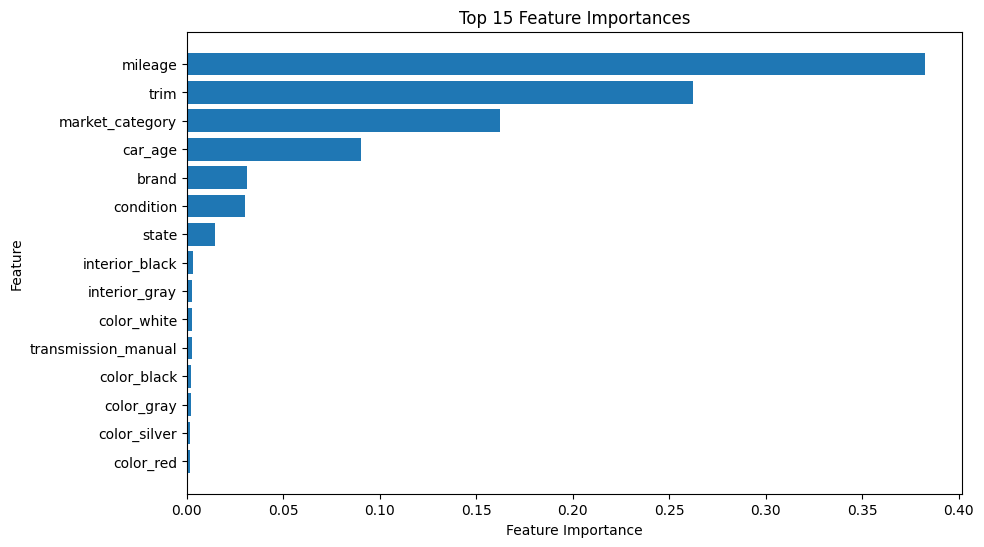

In [73]:
# Feature importance represents the contribution of each feature 
# to reducing prediction error when splitting decision trees

plt.figure(figsize=(10, 6))
plt.barh(importance_price_df['Feature'][:15], importance_price_df['Importance'][:15])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### Exploring the relationship between features and price

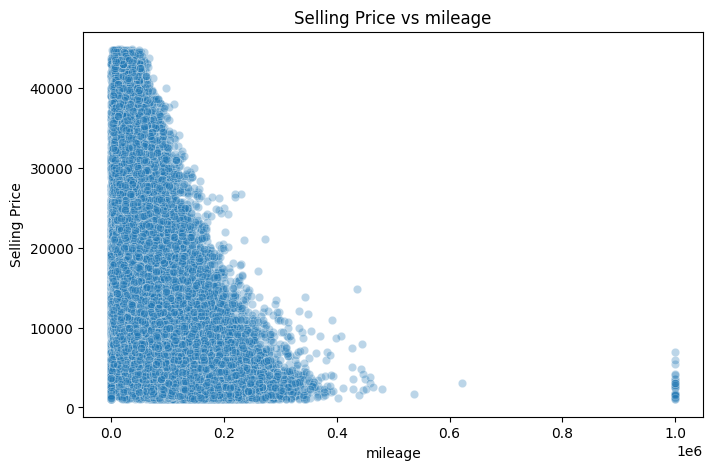

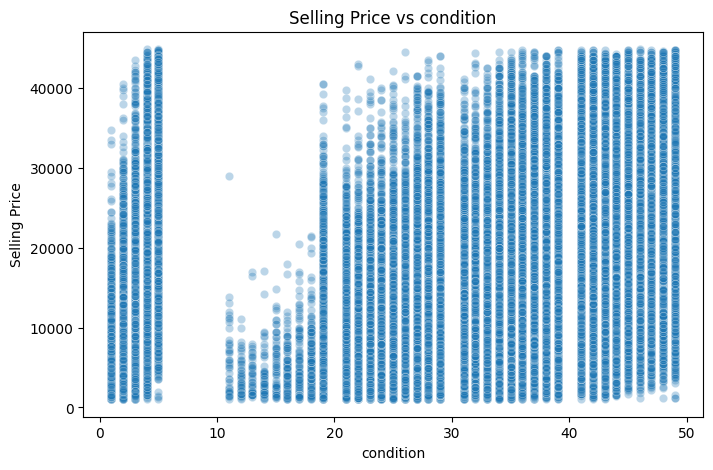

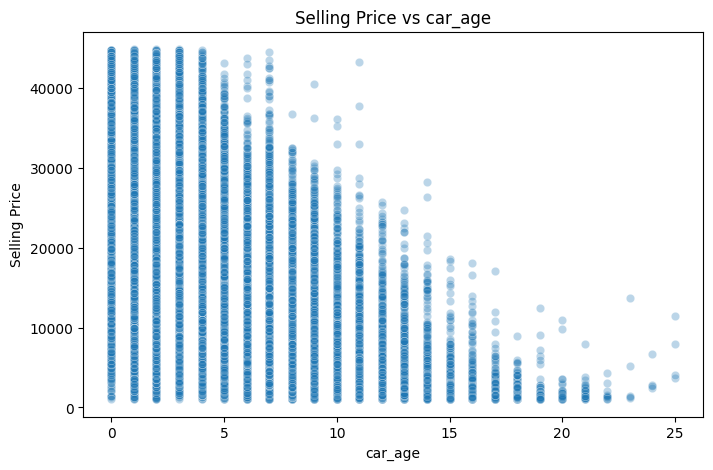

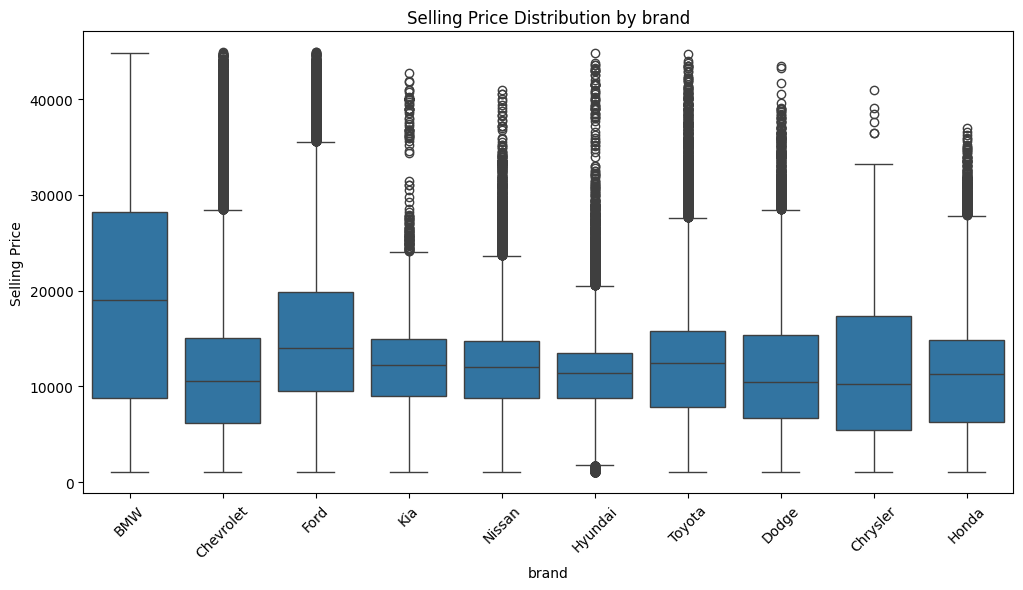

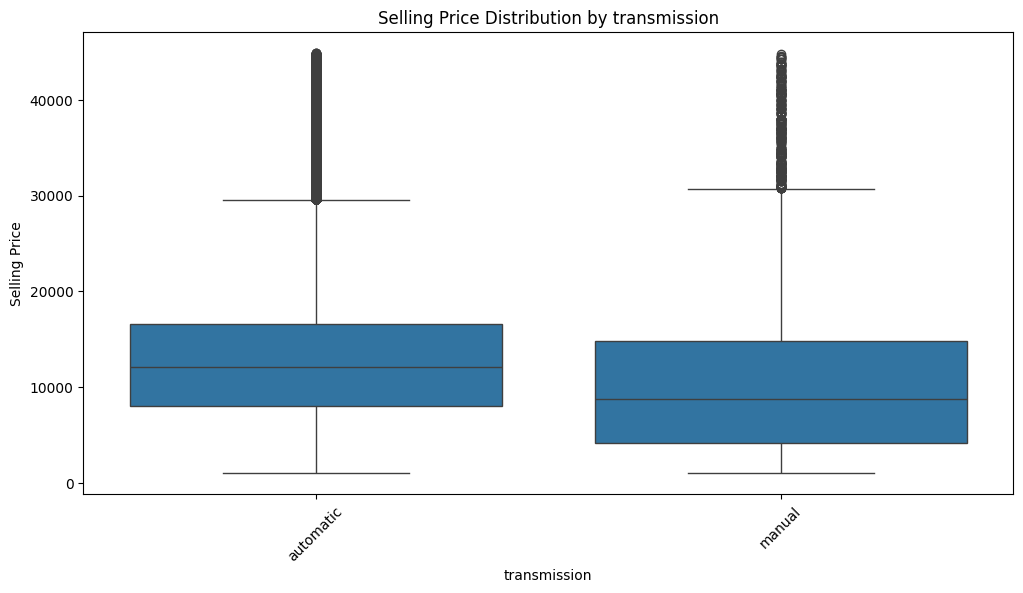

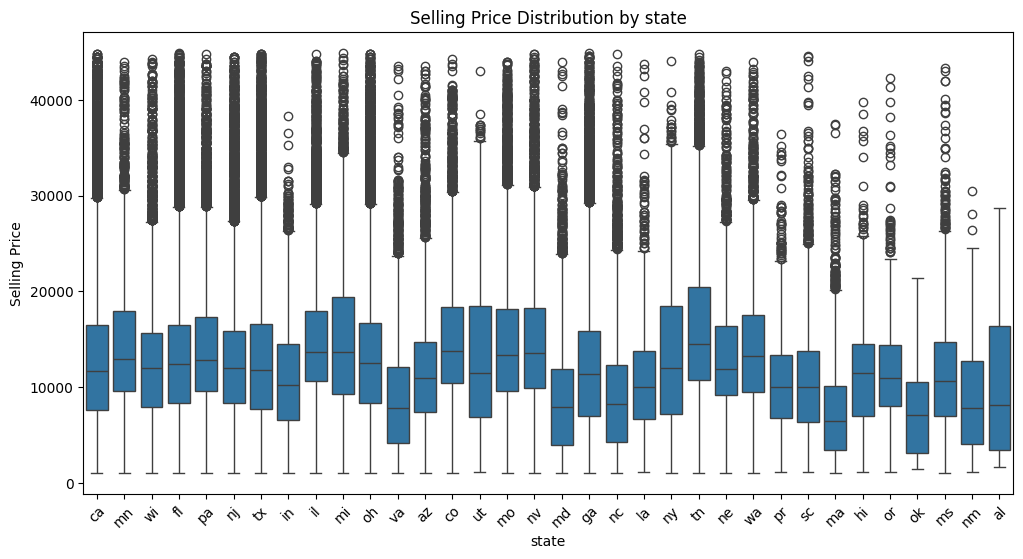

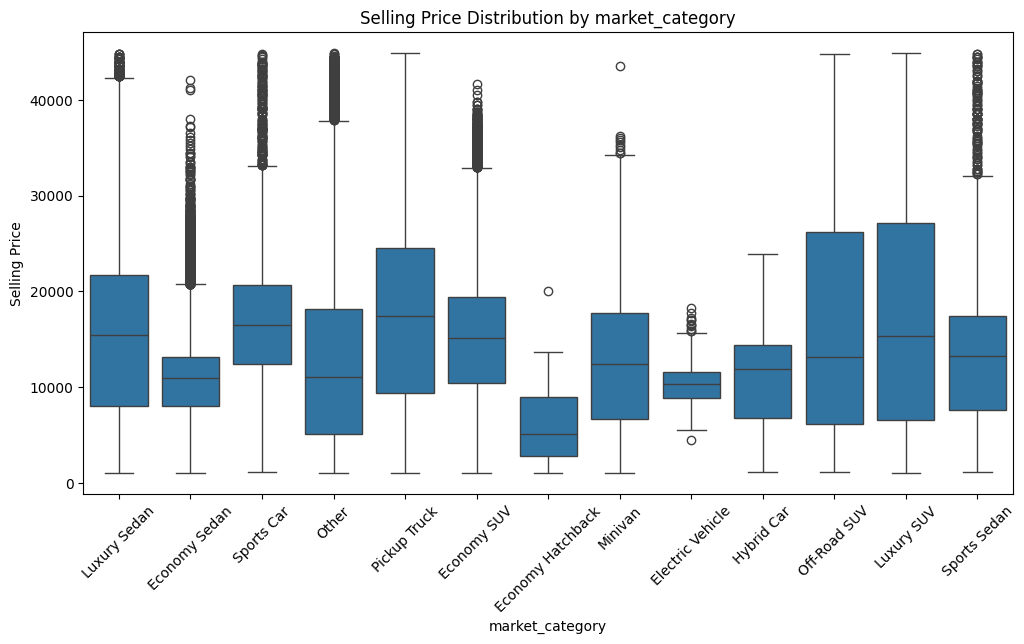

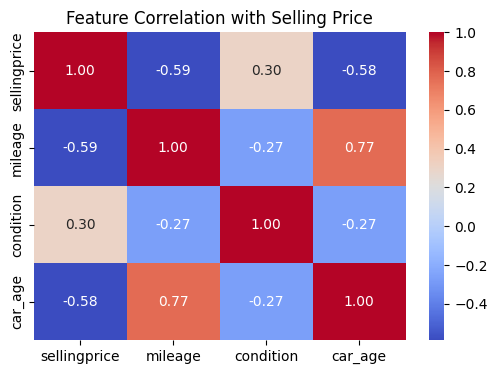

In [74]:
# Scatter plot: visualize the relationship between numeric variables and selling_price
num_features = ['mileage', 'condition', 'car_age']
for feature in num_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df_price[feature], y=df_price['sellingprice'], alpha=0.3)
    plt.xlabel(feature)
    plt.ylabel("Selling Price")
    plt.title(f"Selling Price vs {feature}")
    plt.show()

# Box plot: show the impact of categorical variables on selling price
cat_features = ['brand', 'transmission', 'state', 'market_category']
for feature in cat_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_price[feature], y=df_price['sellingprice'])
    plt.xticks(rotation=45)
    plt.xlabel(feature)
    plt.ylabel("Selling Price")
    plt.title(f"Selling Price Distribution by {feature}")
    plt.show()

# Calculate correlation coefficient
corr_matrix = df_price[['sellingprice', 'mileage', 'condition', 'car_age']].corr()

# Correlation coefficient heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with Selling Price")
plt.show()


### Price Trends and Car Model Recommendations

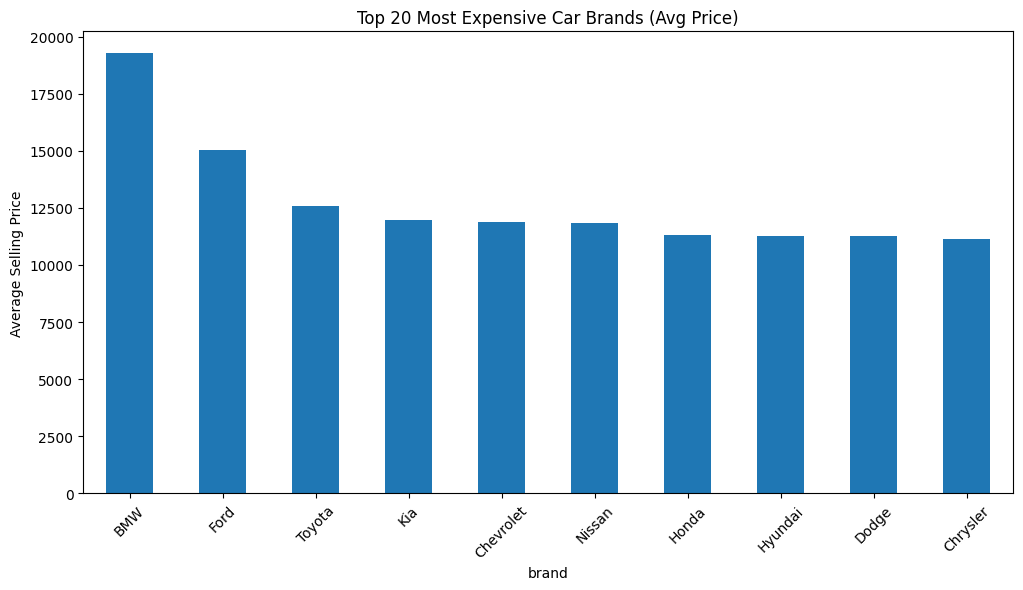

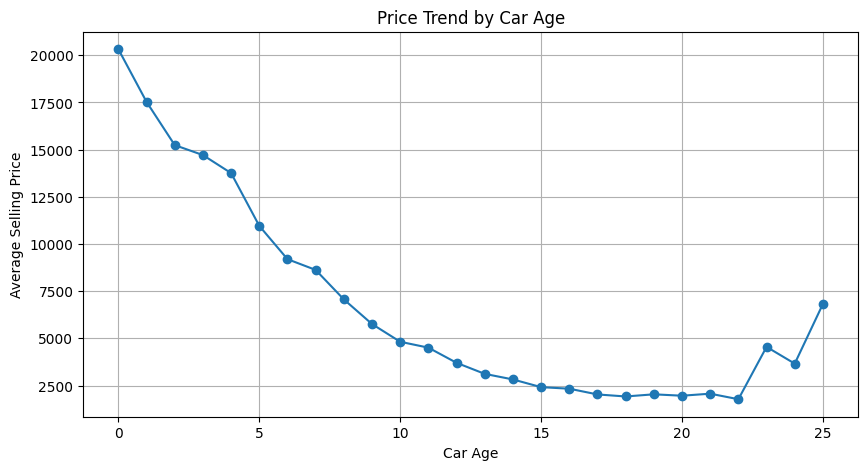

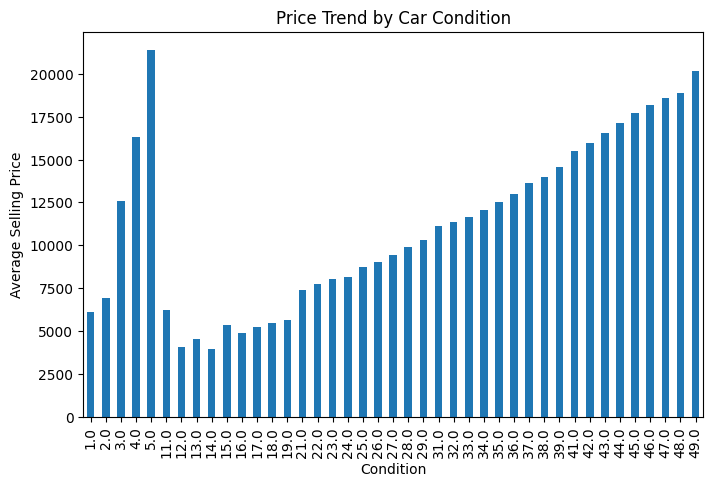

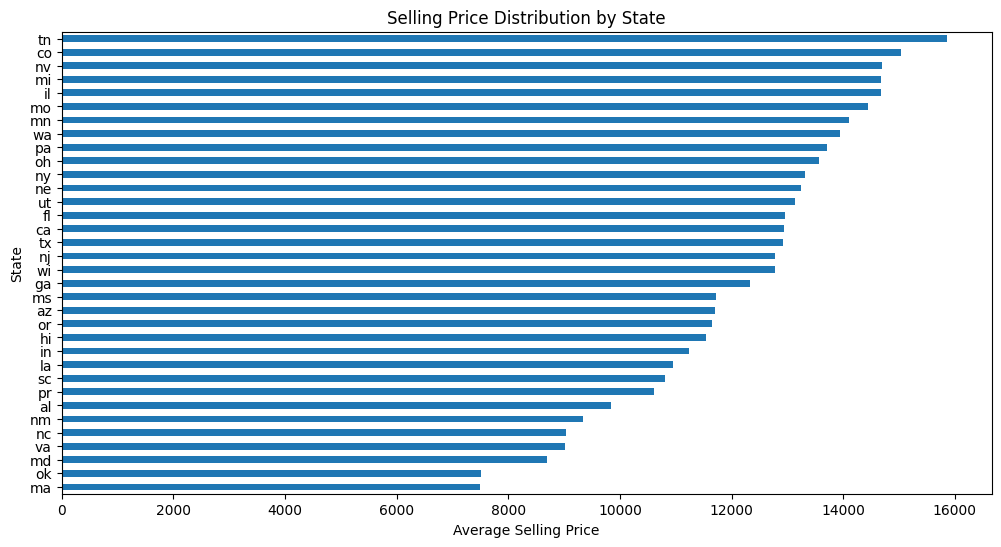

In [75]:
# Brand average price analysis
brand_avg_price = df_price.groupby('brand')['sellingprice'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
brand_avg_price[:20].plot(kind='bar')
plt.ylabel("Average Selling Price")
plt.title("Top 20 Most Expensive Car Brands (Avg Price)")
plt.xticks(rotation=45)
plt.show()

# Average price change by car age
car_age_price = df_price.groupby('car_age')['sellingprice'].mean()

plt.figure(figsize=(10, 5))
car_age_price.plot(marker='o')
plt.xlabel("Car Age")
plt.ylabel("Average Selling Price")
plt.title("Price Trend by Car Age")
plt.grid()
plt.show()

# Average price by condition
condition_price = df_price.groupby('condition')['sellingprice'].mean()

plt.figure(figsize=(8, 5))
condition_price.plot(kind='bar')
plt.xlabel("Condition")
plt.ylabel("Average Selling Price")
plt.title("Price Trend by Car Condition")
plt.show()

# State price difference
state_avg_price = df_price.groupby('state')['sellingprice'].mean().sort_values()

plt.figure(figsize=(12, 6))
state_avg_price.plot(kind='barh')
plt.xlabel("Average Selling Price")
plt.ylabel("State")
plt.title("Selling Price Distribution by State")
plt.show()

### features that make the most contribution to mmr

In [76]:
# Define feature categories
num_features = ['condition', 'mileage', 'car_age']
low_card_cat_features = ['transmission', 'color', 'interior']
high_card_cat_features = ['brand', 'trim', 'state', 'market_category']
target = 'mmr'

# Split the dataset
train, test = train_test_split(df_price, test_size=0.2, random_state=42)

# One-Hot Encoding for low-cardinality categorical features
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
train_ohe = ohe.fit_transform(train[low_card_cat_features])
test_ohe = ohe.transform(test[low_card_cat_features])

# Target Encoding for high-cardinality categorical features
te = TargetEncoder()
train_te = te.fit_transform(train[high_card_cat_features], train[target])
test_te = te.transform(test[high_card_cat_features])

# Combine processed features
X_train = np.hstack((train[num_features].values, train_ohe, train_te))
X_test = np.hstack((test[num_features].values, test_ohe, test_te))

y_train = train[target].values
y_test = test[target].values

# Ensure feature dimensions are reasonable after processing
print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (258676, 43)
Test Shape: (64670, 43)


### random forest - mmr

In [77]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = rf.feature_importances_

# Combine feature names
feature_names = num_features + list(ohe.get_feature_names_out(low_card_cat_features)) + high_card_cat_features

# Convert to DataFrame
importance_mmr_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_mmr_df = importance_mmr_df.sort_values(by='Importance', ascending=False)

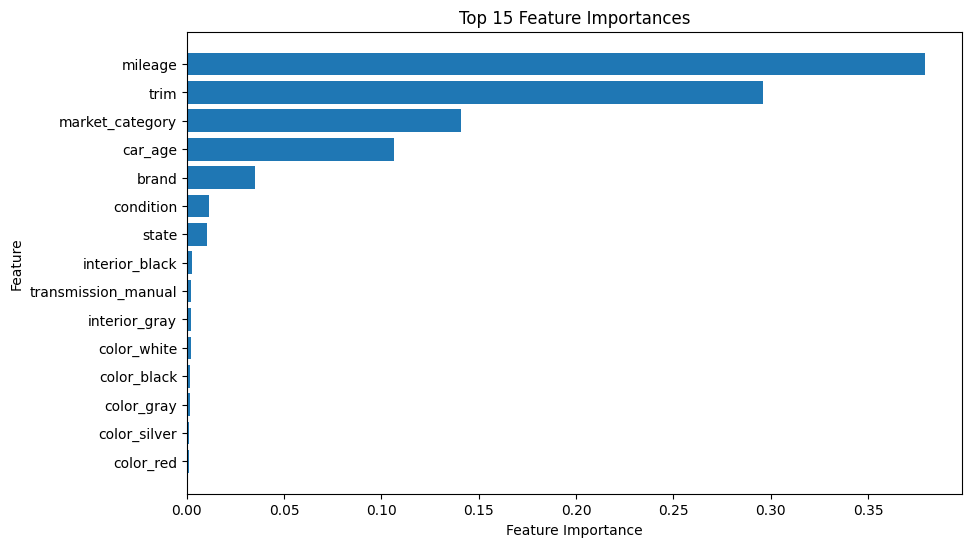

In [78]:
# Feature importance represents the contribution of each feature 
# to reducing prediction error when splitting decision trees

plt.figure(figsize=(10, 6))
plt.barh(importance_mmr_df['Feature'][:15], importance_mmr_df['Importance'][:15])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

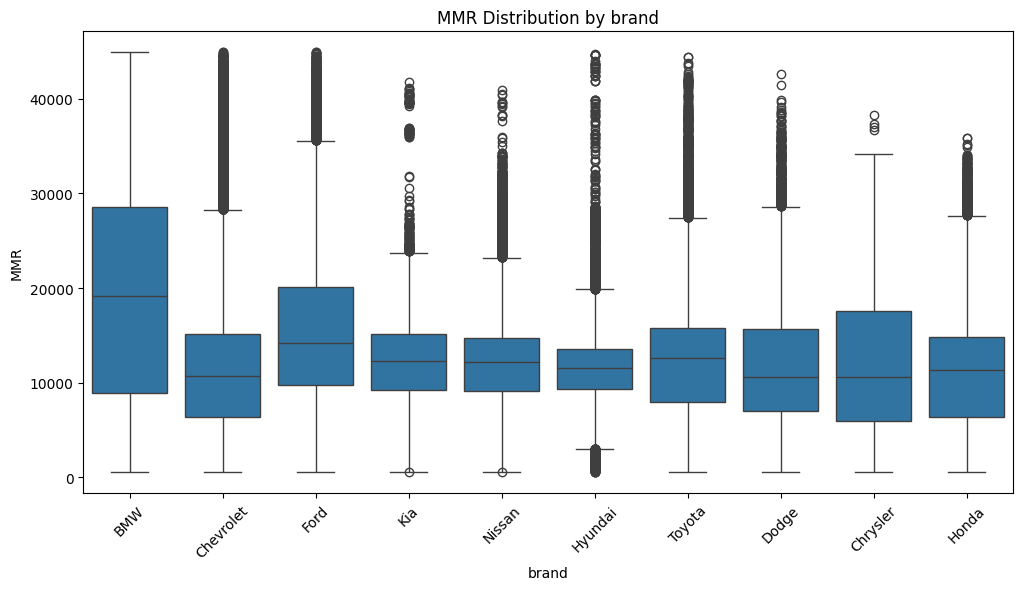

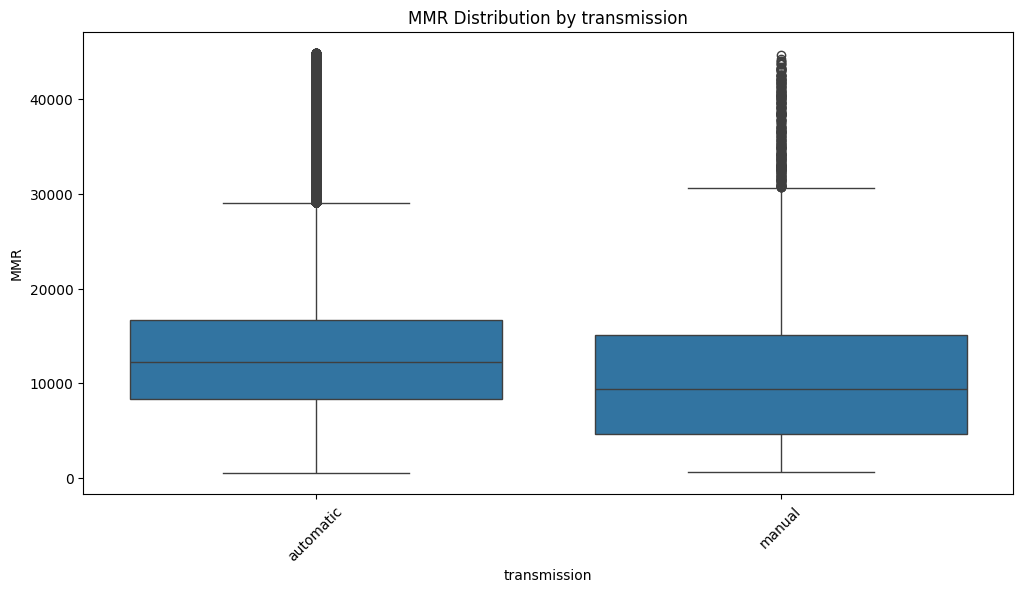

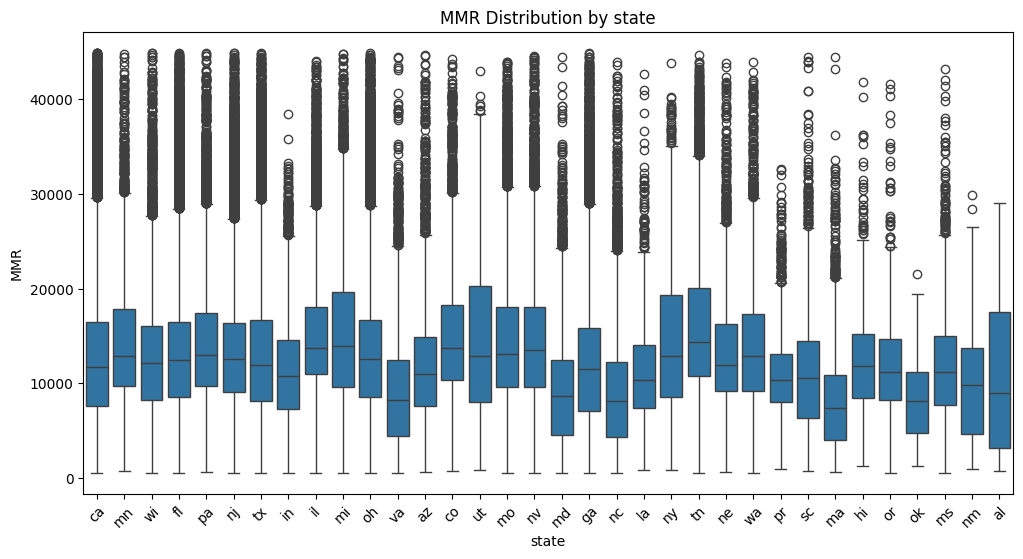

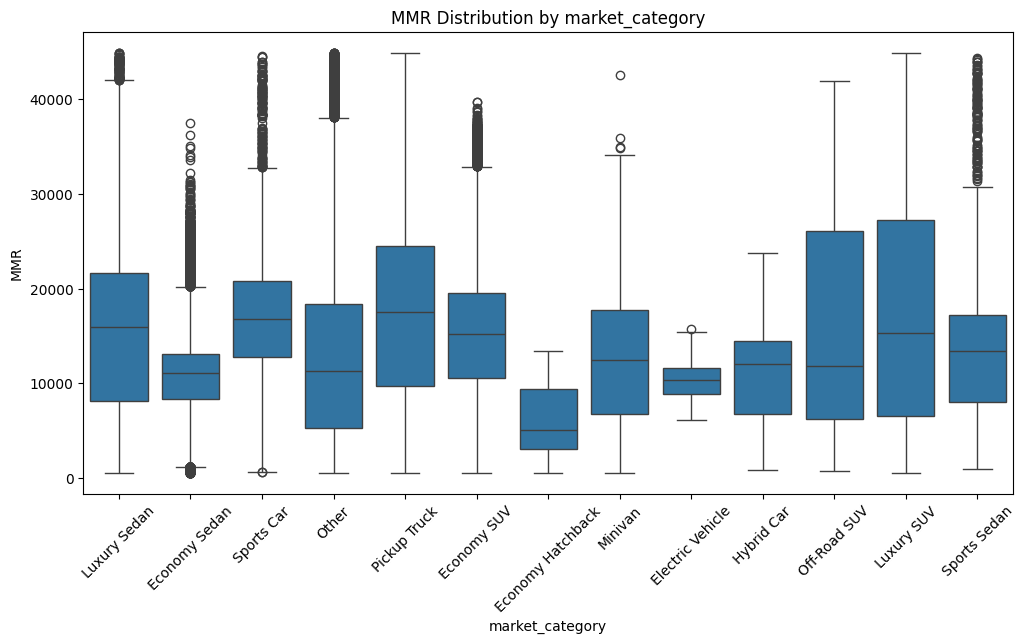

In [79]:
# Box plot: show the impact of categorical variables on mmr
cat_features = ['brand', 'transmission', 'state', 'market_category']
for feature in cat_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_price[feature], y=df_price['mmr'])
    plt.xticks(rotation=45)
    plt.xlabel(feature)
    plt.ylabel("MMR")
    plt.title(f"MMR Distribution by {feature}")
    plt.show()

### Compare common top features for MMR and Selling Price

In [80]:
top_n = 5

top_price_features = importance_price_df.sort_values(by='Importance', ascending=False).head(top_n)['Feature'].tolist()
top_mmr_features = importance_mmr_df.sort_values(by='Importance', ascending=False).head(top_n)['Feature'].tolist()

common_features = list(set(top_price_features) & set(top_mmr_features))

selected_columns = common_features + ['mmr', 'sellingprice']
numeric_cols = df_price[selected_columns].select_dtypes(include='number').columns

df_corr = df_price[numeric_cols].corr()
df_corr[['mmr', 'sellingprice']]

,mmr,sellingprice
mileage,-0.598086,-0.588048
car_age,-0.603699,-0.584931
mmr,1.000000,0.975715
sellingprice,0.975715,1.000000


#### small conclussion: Both mileage and car age are highly negatively correlated with both MMR and selling price, which confirms that usage and vehicle age significantly impact valuation and final transaction price.
#### The extremely high correlation between MMR and selling price (0.98) also suggests that MMR is a strong baseline estimator in this dataset, though potential deviations may exist across brands or segments.

### Analyze features that influence one but not the other¶

In [81]:
top_n = 5

top_price_features = importance_price_df.sort_values(by='Importance', ascending=False).head(top_n)['Feature'].tolist()
top_mmr_features = importance_mmr_df.sort_values(by='Importance', ascending=False).head(top_n)['Feature'].tolist()

price_only = list(set(top_price_features) - set(top_mmr_features))
mmr_only = list(set(top_mmr_features) - set(top_price_features))

price_only_numeric = [f for f in price_only if f in df_price.select_dtypes(include='number').columns]
mmr_only_numeric = [f for f in mmr_only if f in df_price.select_dtypes(include='number').columns]

price_only_corr = df_price[price_only_numeric + ['sellingprice']].corr()['sellingprice'].drop('sellingprice') if price_only_numeric else None
mmr_only_corr = df_price[mmr_only_numeric + ['mmr']].corr()['mmr'].drop('mmr') if mmr_only_numeric else None

price_only_corr, mmr_only_corr

(None, None)

#### At the top 5 level, there are no features that strongly influence only one target (either MMR or Selling Price).
#### This suggests that the key drivers of vehicle valuation and final transaction price are mostly aligned, indicating a consistent pricing pattern between market estimates and consumer behavior.

#   Value Retention Module

In [82]:
#Step 1: Data Loading and Cleaning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("Step 1: Data Loading and Cleaning")
#file_path = '/Users/kat/Downloads/car_prices.csv'
print(f"Loading data from {file_path}...")
#df = pd.read_csv(file_path)

column_mapping = {
    'make': 'brand',
    'body': 'body_type',
    'odometer': 'mileage'
}
for old_col, new_col in column_mapping.items():
    if old_col in df.columns:
        df.rename(columns={old_col: new_col}, inplace=True)

# Remove rows with missing values in key columns
df = df.dropna(subset=['sellingprice', 'mmr', 'mileage', 'year'])

# Extract sale year from the date string and convert to integer
df['sale_year'] = df['saledate'].str[11:15].astype(int)
# Calculate vehicle age (years between sale and manufacturing)
df['car_age'] = df['sale_year'] - df['year']

# Filter out outliers that could skew our analysis
df = df[(df['sellingprice'] > 1000) & (df['sellingprice'] < 100000)]
df = df[(df['mileage'] > 5000) & (df['mileage'] < 200000)]
df = df[df['car_age'] >= 0]  # Remove invalid ages

print(f"Number of records after cleaning: {len(df)}")

# Calculate value retention ratio (selling price / market value)
df['value_retention_ratio'] = (df['sellingprice'] / df['mmr']).round(4)

# Display a sample of the cleaned data
df[['year', 'sale_year', 'car_age', 'sellingprice', 'mmr', 'value_retention_ratio']].head()

Step 1: Data Loading and Cleaning
Loading data from /Users/jenna/OneDrive/桌面/5010 Project/car_prices.csv...
Number of records after cleaning: 441548


,year,sale_year,car_age,sellingprice,mmr,value_retention_ratio
3,2015,2015,0,27750.0,27500.0,1.0091
7,2014,2014,0,9800.0,11900.0,0.8235
8,2014,2014,0,32250.0,32100.0,1.0047
12,2015,2015,0,12000.0,15350.0,0.7818
17,2014,2014,0,40000.0,37100.0,1.0782


In [83]:
#Step 2: Creating Cohorts and Time Periods

print("\nStep 2: Creating Cohorts and Time Periods")

# Group vehicles by manufacturing year to create cohorts
df['cohort'] = df['year']
print(f"Created {df['cohort'].nunique()} cohorts based on manufacturing year")

# Check the distribution of vehicles across cohorts
cohort_counts = df['cohort'].value_counts().sort_index()
print("\nNumber of vehicles in each cohort:")
print(cohort_counts.head(10))  # Show the first 10 cohorts

# Examine the vehicle age distribution
print(f"\nVehicle age range: {df['car_age'].min()} to {df['car_age'].max()} years")
print("\nVehicle age distribution:")
print(df['car_age'].value_counts().sort_index().head(10))  # Show first 10 ages


Step 2: Creating Cohorts and Time Periods
Created 26 cohorts based on manufacturing year

Number of vehicles in each cohort:
cohort
1990      7
1991     12
1992     16
1993     19
1994     45
1995     85
1996    118
1997    316
1998    531
1999    917
Name: count, dtype: int64

Vehicle age range: 0 to 25 years

Vehicle age distribution:
car_age
0     9545
1    66075
2    85984
3    84207
4    39092
5    21968
6    18316
7    26271
8    24093
9    19852
Name: count, dtype: int64


In [84]:
# Step 3: Cohort Analysis Creation & Build the cohort analysis
print("\nStep 3: Building Cohort Analysis")

# Group data by cohort and vehicle age, then calculate average retention ratio
cohort_data = df.groupby(['cohort', 'car_age'])['value_retention_ratio'].agg(['mean', 'count']).reset_index()
print("Sample of cohort data:")
print(cohort_data.head())

# Create a pivot table for easier visualization and analysis
cohort_pivot = cohort_data.pivot_table(
    index='cohort',
    columns='car_age',
    values='mean'
)

print("\nValue retention ratio pivot table:")
print(cohort_pivot.head())

# Create a sample size pivot table to validate our insights
count_pivot = cohort_data.pivot_table(
    index='cohort',
    columns='car_age',
    values='count'
)

print("\nSample sizes for each cohort-age combination:")
print(count_pivot.head())


Step 3: Building Cohort Analysis
Sample of cohort data:
   cohort  car_age      mean  count
0    1990       25  1.051500      7
1    1991       23  1.127500      3
2    1991       24  0.913267      9
3    1992       22  1.854800      2
4    1992       23  1.250386     14

Value retention ratio pivot table:
car_age  0   1   2   3   4   5   6   7   8   9   ...  16  17  18  19  \
cohort                                           ...                   
1990    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
1991    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
1992    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
1993    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   
1994    NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN NaN   

car_age        20        21        22        23        24      25  
cohort                                                             
1990          NaN       NaN       NaN       NaN   


Step 4: Visualizing Retention Patterns


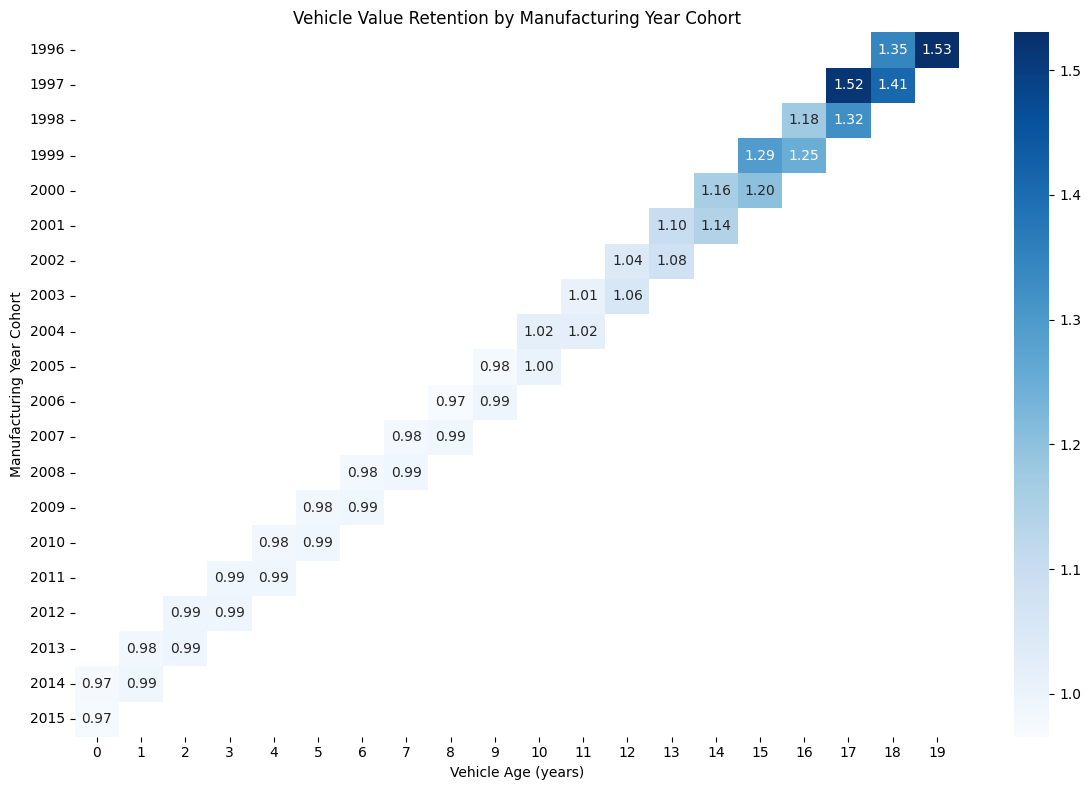

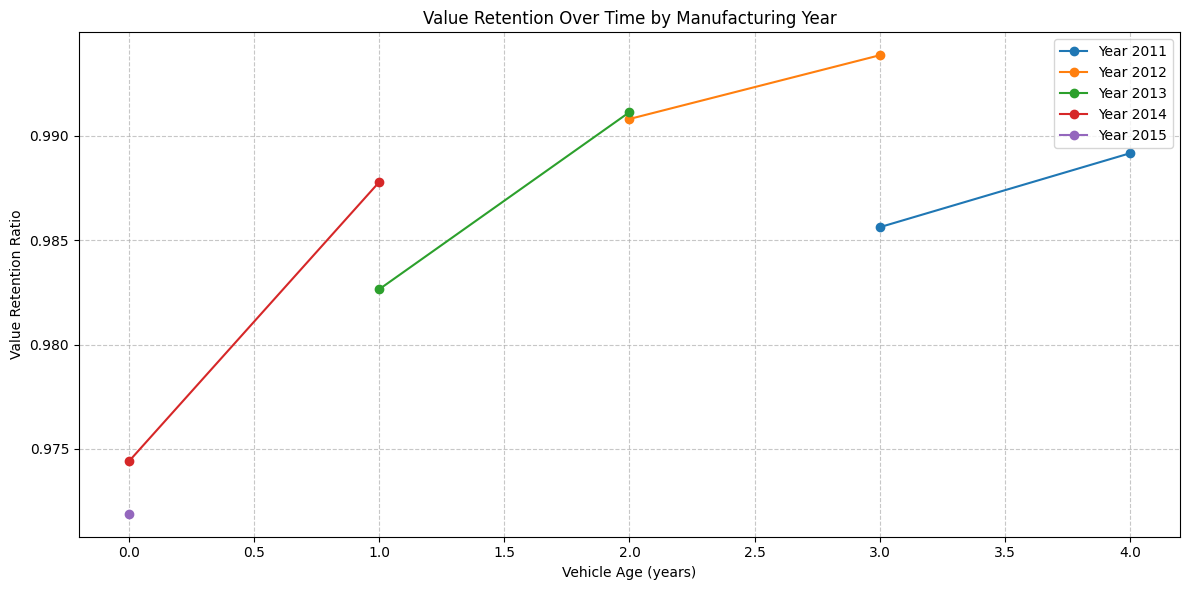

In [85]:
# Step 4: Visualization & Visualize the retention patterns
print("\nStep 4: Visualizing Retention Patterns")

# filter to include only cohorts and ages with sufficient data
# just setting a minimum threshold of 100 samples per cohort
valid_cohorts = count_pivot.index[count_pivot.sum(axis=1) >= 100]
# minimum of 100 samples per age bracket
valid_ages = count_pivot.columns[count_pivot.sum() >= 100]

# filter the pivot table
filtered_pivot = cohort_pivot.loc[valid_cohorts, valid_ages]

# create a heatmap to visualize retention patterns
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_pivot, annot=True, fmt='.2f', cmap='Blues')
plt.title('Vehicle Value Retention by Manufacturing Year Cohort')
plt.xlabel('Vehicle Age (years)')
plt.ylabel('Manufacturing Year Cohort')
plt.tight_layout()
plt.show()

# create a line chart to compare retention curves by year
plt.figure(figsize=(12, 6))
for year in sorted(filtered_pivot.index)[-5:]:  # Select the 5 most recent years
    if year in filtered_pivot.index:
        plt.plot(filtered_pivot.columns, filtered_pivot.loc[year], marker='o', label=f'Year {year}')

plt.title('Value Retention Over Time by Manufacturing Year')
plt.xlabel('Vehicle Age (years)')
plt.ylabel('Value Retention Ratio')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [86]:
# Step 5: Interpretation and Value Retention Insights
print("\n Step 5: Interpretation and Value Retention Insights")

# 1. Average value retention by vehicle age
avg_retention = filtered_pivot.mean(axis=0)
print("\n Average Value Retention Ratio by Vehicle Age:")
for age, retention in avg_retention.items():
    print(f"Age {age} years: {retention:.2f}")

# 2. Best manufacturing cohorts based on overall retention
best_years = filtered_pivot.mean(axis=1).sort_values(ascending=False)
print("\n Manufacturing Years Ranked by Average Value Retention:")
for year, retention in best_years.head(5).items():
    print(f"Year {year}: {retention:.2f}")

# 3. Top value-retaining models (model-level retention)
print("\n Top 10 Value-Retaining Models:")

# Step 1: Ensure meter_value_ratio exists
if 'meter_value_ratio' not in df.columns:
    df['meter_value_ratio'] = df['mileage'] / df['sellingprice']

# Step 2: Aggregate by brand and model
model_summary = df.groupby(['brand', 'model']).agg(
    avg_retention=('value_retention_ratio', 'mean'),
    avg_meter_value=('meter_value_ratio', 'mean'),
    count=('value_retention_ratio', 'count')
).reset_index()

# Step 3: Filter for reliable entries (min sample size)
filtered_models = model_summary[model_summary['count'] >= 30]

# Step 4: Sort by average retention
top_models = filtered_models.sort_values(by='avg_retention', ascending=False)

# Step 5: Display top 10 models
if not top_models.empty:
    print(top_models.head(10))
else:
    print(" No model combinations with at least 30 records found.")



 Step 5: Interpretation and Value Retention Insights

 Average Value Retention Ratio by Vehicle Age:
Age 0 years: 0.97
Age 1 years: 0.99
Age 2 years: 0.99
Age 3 years: 0.99
Age 4 years: 0.99
Age 5 years: 0.99
Age 6 years: 0.98
Age 7 years: 0.98
Age 8 years: 0.98
Age 9 years: 0.98
Age 10 years: 1.01
Age 11 years: 1.01
Age 12 years: 1.05
Age 13 years: 1.09
Age 14 years: 1.15
Age 15 years: 1.25
Age 16 years: 1.21
Age 17 years: 1.42
Age 18 years: 1.38
Age 19 years: 1.53

 Manufacturing Years Ranked by Average Value Retention:
Year 1997: 1.46
Year 1996: 1.44
Year 1999: 1.27
Year 1998: 1.25
Year 2000: 1.18

 Top 10 Value-Retaining Models:
          brand        model  avg_retention  avg_meter_value  count
351       Isuzu        Rodeo       1.438718        66.659634     34
608      Saturn     S-Series       1.411744        79.762051     66
558  Oldsmobile        Alero       1.336918        79.187762     33
429     Lincoln  Continental       1.329761        64.644494     31
244        Ford   


Step 6: Advanced Insights – Model-Level & Statistical Analysis


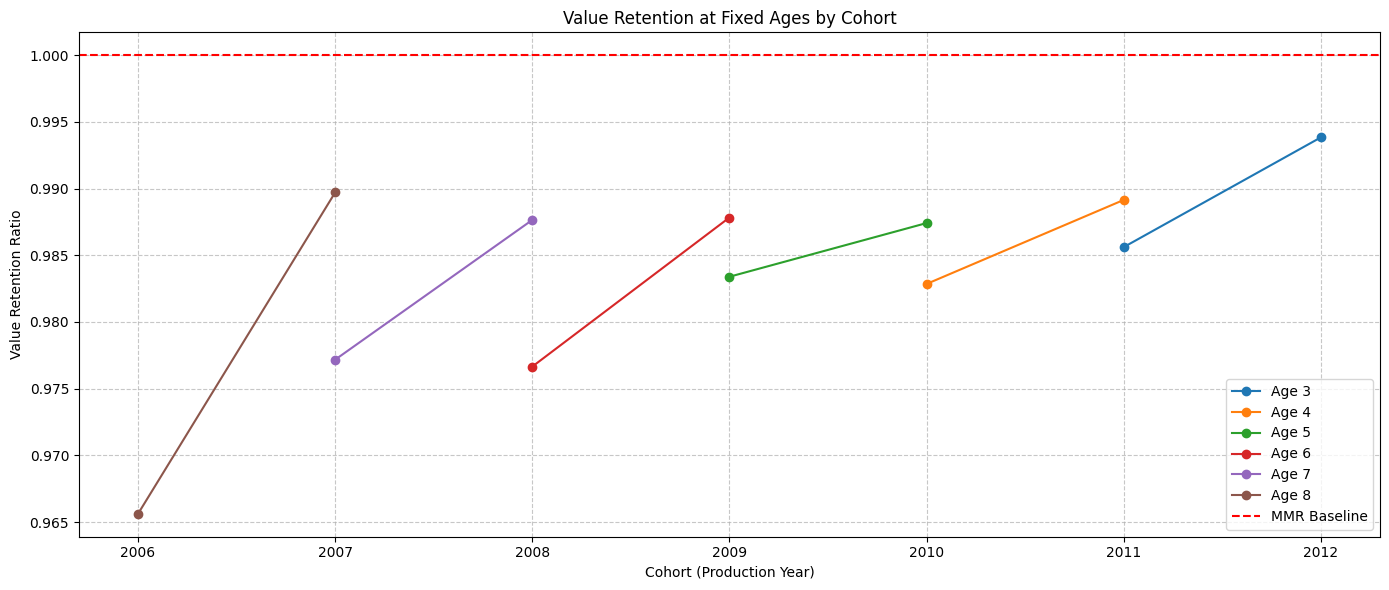


Top 10 Value-Retaining Models:
          brand        model  avg_retention  avg_meter_value  count
351       Isuzu        Rodeo       1.438718        66.659634     34
608      Saturn     S-Series       1.411744        79.762051     66
558  Oldsmobile        Alero       1.336918        79.187762     33
429     Lincoln  Continental       1.329761        64.644494     31
244        Ford     Windstar       1.322989        86.665115     45
160    Chrysler         300M       1.321932        74.330692     37
155   Chevrolet      Venture       1.315341        89.482717     71
579     Pontiac      Sunfire       1.312929        66.820544     31
476       Mazda      Protege       1.298987        81.108621     40
0         Acura           CL       1.291471        64.269988     56

Regression Summary: Value Retention ~ Car Age + Cohort
                              OLS Regression Results                             
Dep. Variable:     value_retention_ratio   R-squared:                       0.000


In [87]:
# Step 6: Advanced Insights – Model-Level & Statistical Analysis
print("\nStep 6: Advanced Insights – Model-Level & Statistical Analysis")

# 1. Analyze value retention across cohorts at fixed vehicle ages
fixed_ages = [3, 4, 5, 6, 7, 8]
plt.figure(figsize=(14, 6))
for age in fixed_ages:
    age_df = df[df['car_age'] == age].groupby('cohort')['value_retention_ratio'].mean().reset_index()
    plt.plot(age_df['cohort'], age_df['value_retention_ratio'], marker='o', label=f'Age {age}')
plt.title('Value Retention at Fixed Ages by Cohort')
plt.xlabel('Cohort (Production Year)')
plt.ylabel('Value Retention Ratio')
plt.axhline(y=1.0, color='red', linestyle='--', label='MMR Baseline')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Analyze value retention and usage efficiency by brand and model
df['meter_value_ratio'] = df['mileage'] / df['sellingprice']

model_summary = df.groupby(['brand', 'model']).agg(
    avg_retention=('value_retention_ratio', 'mean'),
    avg_meter_value=('meter_value_ratio', 'mean'),
    count=('value_retention_ratio', 'count')
).reset_index()

# Filter for reliable combinations with sufficient sample size
filtered_models = model_summary[model_summary['count'] >= 30]

# Sort by average retention ratio to find top-performing models
top_models = filtered_models.sort_values(by='avg_retention', ascending=False)

print("\nTop 10 Value-Retaining Models:")
print(top_models.head(10))

# 3. Quantify the impact of vehicle age and manufacturing cohort using regression
import statsmodels.formula.api as smf

# Limit the dataset to vehicles 10 years old or younger
model_df = df[df['car_age'] <= 10]

# Fit an OLS regression model
model = smf.ols('value_retention_ratio ~ car_age + cohort', data=model_df).fit()

print("\nRegression Summary: Value Retention ~ Car Age + Cohort")
print(model.summary())



Step 7: Value Retention by Vehicle Type

Average value retention ratio by vehicle type:
              body_type      mean   count
28      Q60 Convertible  1.047955      33
74             supercab  1.038159     682
7              Club Cab  1.027531     121
56         extended cab  1.024912     568
71          regular cab  1.019084     619
21        Genesis Coupe  1.012884     188
2             CTS Coupe  1.012849     101
49          crewmax cab  1.012275     104
39                  Van  1.011033    2632
9                 Coupe  1.010928   11446
8           Convertible  1.010277    6864
79                  van  1.010179     403
29            Q60 Coupe  1.008683      30
25             Mega Cab  1.007321      42
66              minivan  1.007306    3408
80                wagon  1.006533    2054
46          convertible  1.006049    1380
47                coupe  1.006047    2449
57        g convertible  1.003878      69
32          Regular Cab  1.003672    2949
54         e-series van  1.00

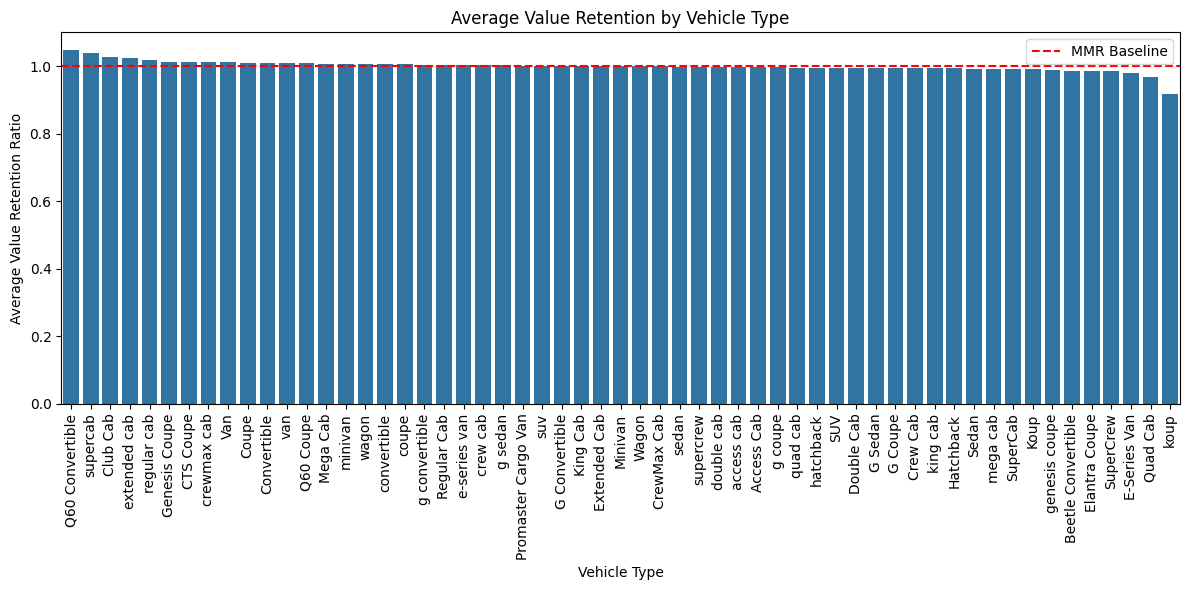


Value retention at age 5 by vehicle type:
       body_type      mean  count
22           Van  1.024804     92
43     supercrew  1.012207    159
4    CrewMax Cab  0.999667     48
1    Convertible  0.999344    200
25         coupe  0.997744    217
40   regular cab  0.997718     38
18           SUV  0.995763   4959
3       Crew Cab  0.995694    706
42      supercab  0.995235     68
2          Coupe  0.994883    865
39      quad cab  0.994478     40
26      crew cab  0.993647    174
31  extended cab  0.993476     46
44           suv  0.991789   1117
11     Hatchback  0.991618    839
7   Extended Cab  0.990947    193
38       minivan  0.990600    179
17   Regular Cab  0.988733    148
20      SuperCab  0.986557    370
23         Wagon  0.985040    865
15       Minivan  0.984868    893
21     SuperCrew  0.982129    635
19         Sedan  0.979941   7017
16      Quad Cab  0.979796    147
41         sedan  0.977310   1427
24   convertible  0.976727     45
46         wagon  0.971584    178
34   

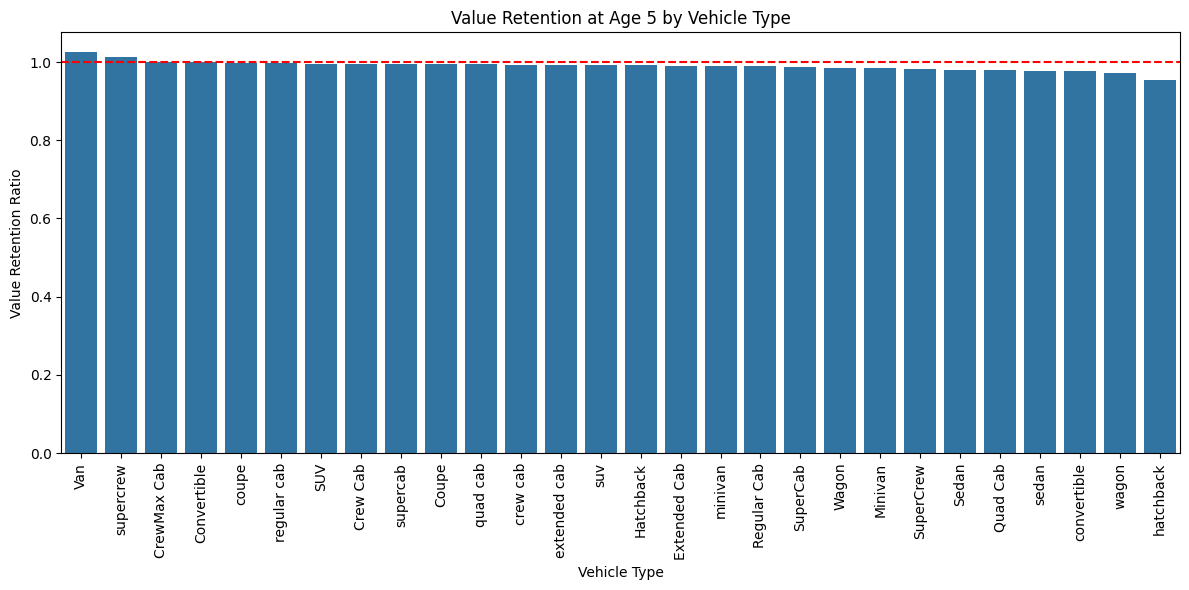

In [88]:
# Step 7: Value Retention by Vehicle Type
print("\nStep 7: Value Retention by Vehicle Type")

# 1. Average value retention by vehicle type
if 'body_type' in df.columns:
    body_retention = df.groupby('body_type')['value_retention_ratio'].agg(['mean', 'count']).reset_index()
    body_retention = body_retention[body_retention['count'] >= 30].sort_values('mean', ascending=False)

    print("\nAverage value retention ratio by vehicle type:")
    print(body_retention)

    # Visualization
    plt.figure(figsize=(12, 6))
    sns.barplot(data=body_retention, x='body_type', y='mean')
    plt.axhline(y=1.0, color='red', linestyle='--', label='MMR Baseline')
    plt.title('Average Value Retention by Vehicle Type')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Average Value Retention Ratio')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Value retention at a fixed vehicle age (e.g., age 5) by type
    age_focus = 5
    age_df = df[df['car_age'] == age_focus]
    type_age_retention = age_df.groupby('body_type')['value_retention_ratio'].agg(['mean', 'count']).reset_index()
    type_age_retention = type_age_retention[type_age_retention['count'] >= 30].sort_values('mean', ascending=False)

    print(f"\nValue retention at age {age_focus} by vehicle type:")
    print(type_age_retention)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=type_age_retention, x='body_type', y='mean')
    plt.title(f'Value Retention at Age {age_focus} by Vehicle Type')
    plt.axhline(y=1.0, color='red', linestyle='--')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Value Retention Ratio')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Column 'body_type' not found in dataset.")

## Modular Design & Packaging Plan

To improve maintainability and allow the project to be reused and extended, this analysis is structured into a modular Python package. Each component (data cleaning, modeling, cohort analysis, visualization, etc.) is encapsulated in its own module.

### Suggested Project Structure



DS5010/
├── main.ipynb
├── car_prices.csv
└── used_car_analysis/
    ├── __init__.py
    ├── preprocessing.py
    ├── modeling.py
    ├── retention_analysis.py
    ├── cohort_analysis.py
    └── visualization.py




This modular design supports better readability, reusability, and scalability. It also facilitates future deployment or sharing as a reusable analytics toolkit for vehicle depreciation studies.



In [89]:
import os
os.getcwd()


'C:\\Users\\jenna\\OneDrive\\桌面\\5010 Project'

In [90]:
os.chdir('/Users/liziqi/NEU/DS5010')  
import os

folder = 'used_car_analysis'
files = [
    '__init__.py',
    'preprocessing.py',
    'modeling.py',
    'retention_analysis.py',
    'cohort_analysis.py',
    'visualization.py'
]

# creat folder
os.makedirs(folder, exist_ok=True)

for file in files:
    open(os.path.join(folder, file), 'a').close()

print("Module folder and files created!")


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/liziqi/NEU/DS5010'

In [ ]:
# Project Structure Breakdown

# Folder: used_car_analysis

# 1. Data Preprocessing Module
# File: preprocessing.py


import pandas as pd

def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df = df.rename(columns={
        'make': 'brand',
        'body': 'body_type',
        'odometer': 'mileage'})
    df = df.dropna(subset=['sellingprice', 'mmr', 'mileage', 'year'])
    df['sale_year'] = df['saledate'].str[11:15].astype(int)
    df['car_age'] = df['sale_year'] - df['year']
    df = df[(df['sellingprice'] > 1000) & (df['sellingprice'] < 100000)]
    df = df[(df['mileage'] > 5000) & (df['mileage'] < 200000)]
    df = df[df['car_age'] >= 0]
    df['value_retention_ratio'] = (df['sellingprice'] / df['mmr']).round(4)
    return df


# 2. Modeling Module
# File: modeling.py
# Includes Random Forest, XGBoost, OLS regression, etc.
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

def train_xgboost(X_train, y_train):
    model = XGBRegressor()
    model.fit(X_train, y_train)
    return model

def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    return rf

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    return {
        "Train_R2": r2_score(y_train, y_pred_train),
        "Test_R2": r2_score(y_test, y_pred_test),
        "Train_RMSE": sqrt(mean_squared_error(y_train, y_pred_train)),
        "Test_RMSE": sqrt(mean_squared_error(y_test, y_pred_test)),
    }


# 3. Retention Analysis Module
# File: retention_analysis.py
# Calculates model-level value retention and meter/value ratio.
def calculate_meter_value_ratio(df):
    df['meter_value_ratio'] = df['mileage'] / df['sellingprice']
    return df

def get_top_models_by_retention(df, min_count=30):
    model_summary = df.groupby(['brand', 'model']).agg(
        avg_retention=('value_retention_ratio', 'mean'),
        avg_meter_value=('meter_value_ratio', 'mean'),
        count=('value_retention_ratio', 'count')
    ).reset_index()
    return model_summary[model_summary['count'] >= min_count].sort_values(by='avg_retention', ascending=False)


# 4. Cohort Analysis Module
# File: cohort_analysis.py
# Cohort tracking, pivot table generation, heatmap preparation.
def build_cohort_pivot(df):
    df['cohort'] = df['year']
    cohort_data = df.groupby(['cohort', 'car_age'])['value_retention_ratio'].agg(['mean', 'count']).reset_index()
    pivot = cohort_data.pivot(index='cohort', columns='car_age', values='mean')
    count = cohort_data.pivot(index='cohort', columns='car_age', values='count')
    return pivot, count


# 5. Visualization Module
# File: visualization.py
# Functions for plotting retention curves, comparisons, etc.
import matplotlib.pyplot as plt
import seaborn as sns

def plot_retention_heatmap(pivot, title='Retention Heatmap'):
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, annot=True, fmt='.2f', cmap='Blues')
    plt.title(title)
    plt.xlabel('Vehicle Age')
    plt.ylabel('Cohort')
    plt.tight_layout()
    plt.show()

def plot_line_by_cohort(pivot, years):
    plt.figure(figsize=(12, 6))
    for year in years:
        plt.plot(pivot.columns, pivot.loc[year], marker='o', label=f'Year {year}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# 6. __init__.py
# Empty init file to enable Python package behavior


# 7. main.ipynb
# Jupyter Notebook that orchestrates all modules above in a full analysis pipeline

import sys
sys.path.append('/Users/liziqi/NEU/DS5010')  
from used_car_analysis.preprocessing import load_and_clean_data
from used_car_analysis.retention_analysis import calculate_meter_value_ratio, get_top_models_by_retention
from used_car_analysis.cohort_analysis import build_cohort_pivot
from used_car_analysis.visualization import plot_retention_heatmap, plot_line_by_cohort

'''
df = load_and_clean_data('/Users/liziqi/NEU/DS5010/car_prices.csv')
df = calculate_meter_value_ratio(df)
top_models = get_top_models_by_retention(df)
pivot, count = build_cohort_pivot(df)
plot_retention_heatmap(pivot)
'''


In [ ]:
#test package
from used_car_analysis.preprocessing import load_and_clean_data
df = load_and_clean_data('/Users/liziqi/NEU/DS5010/car_prices.csv')
df = calculate_meter_value_ratio(df)
top_models = get_top_models_by_retention(df)
pivot, count = build_cohort_pivot(df)
plot_retention_heatmap(pivot)
